In [27]:
import rasterio
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

In [28]:
import os
import rasterio

def load_images_from_folder(root_folder):
    images = []
    labels = []
    for class_folder in os.listdir(root_folder):
        class_folder_path = os.path.join(root_folder, class_folder)
        if os.path.isdir(class_folder_path):
            for filename in os.listdir(class_folder_path):
                if filename.endswith('.tif'):
                    img_path = os.path.join(class_folder_path, filename)
                    try:
                        img = rasterio.open(img_path)
                        images.append(img.read().transpose((1, 2, 0)))
                        labels.append(class_folder)  # The label is the name of the parent directory
                    except RasterioIOError:
                        print(f'Failed to load {img_path}. Skipping.')
    return np.array(images), np.array(labels)

In [29]:
data, labels = load_images_from_folder('/kaggle/input/eurosat-dataset/EuroSATallBands')

In [30]:
data = data.astype("float32") / 65535  # Assuming the pixel values range from 0 to 65535 
data = data.reshape(data.shape[0], 64, 64, 13)  # Reshape images to add a channel dimension 

In [31]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=69, stratify=labels)

In [32]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (22077, 64, 64, 13)
Shape of x_test: (5520, 64, 64, 13)
Shape of y_train: (22077,)
Shape of y_test: (5520,)


In [33]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 13)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512),
    Dense(256),
    Dense(128),
    Dense(10, activation='softmax')
])

In [34]:
import tensorflow as tf

In [35]:
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 16)        1888      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [37]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the encoder
encoder = LabelEncoder()

# Fit the encoder and transform the labels
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Now use the encoded labels to train the model
history = model.fit(x_train, y_train_encoded, epochs=70, validation_data=(x_test, y_test_encoded))

Epoch 1/70
690/690 [==============================] - 6s 8ms/step - loss: 0.9749 - sparse_categorical_accuracy: 0.6506 - val_loss: 0.6578 - val_sparse_categorical_accuracy: 0.7873
Epoch 2/70
690/690 [==============================] - 5s 7ms/step - loss: 0.6024 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.5289 - val_sparse_categorical_accuracy: 0.8056
Epoch 3/70
690/690 [==============================] - 5s 7ms/step - loss: 0.4852 - sparse_categorical_accuracy: 0.8308 - val_loss: 0.3795 - val_sparse_categorical_accuracy: 0.8766
Epoch 4/70
690/690 [==============================] - 5s 7ms/step - loss: 0.3992 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.3536 - val_sparse_categorical_accuracy: 0.8812
Epoch 5/70
690/690 [==============================] - 5s 7ms/step - loss: 0.3463 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.3511 - val_sparse_categorical_accuracy: 0.8819
Epoch 6/70
690/690 [==============================] - 5s 7ms/step - loss: 0.3162 - sparse_categorica

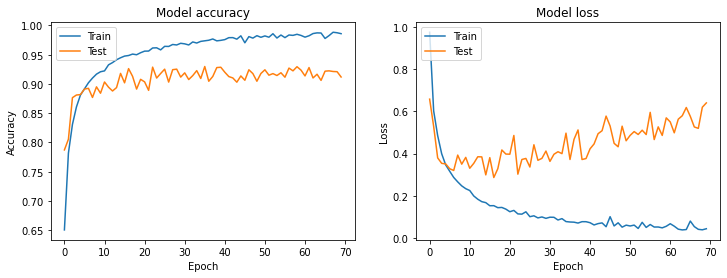

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

In [40]:
# Now compute precision, recall, and F1-score
precision, recall, f1score, support = precision_recall_fscore_support(y_test_encoded, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1score}")
print(f"Support: {support}")
print(f"Accuracy: {accuracy}")

Precision: 0.9146613473452955
Recall: 0.9119565217391304
F1-score: 0.9124411483370152
Support: None
Accuracy: 0.9119565217391304


In [41]:
class_names = ['AnnualCrop','Forest', 'HerbaceousVegetation',
                 'Highway', 'Industrial', 'Pasture',
                 'PermanentCrop', 'Residential', 'River',
                 'SeaLake']

In [42]:
from sklearn.metrics import classification_report

# Get the predicted probabilities
y_pred_prob = model.predict(x_test)

# Get the predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels
y_true = y_test_encoded  # Replace with your true labels
import pandas as pd
# Print the classification report
report = classification_report(y_true, y_pred, target_names=class_names,output_dict=True)
report = pd.DataFrame(report).transpose()
print(report)

                      precision    recall  f1-score      support
AnnualCrop             0.903114  0.870000  0.886248   600.000000
Forest                 0.976311  0.961667  0.968934   600.000000
HerbaceousVegetation   0.913274  0.860000  0.885837   600.000000
Highway                0.885246  0.864000  0.874494   500.000000
Industrial             0.899811  0.952000  0.925170   500.000000
Pasture                0.849642  0.890000  0.869353   400.000000
PermanentCrop          0.777193  0.886000  0.828037   500.000000
Residential            0.911475  0.926667  0.919008   600.000000
River                  0.988739  0.878000  0.930085   500.000000
SeaLake                0.987603  0.995833  0.991701   720.000000
accuracy               0.911957  0.911957  0.911957     0.911957
macro avg              0.909241  0.908417  0.907887  5520.000000
weighted avg           0.914661  0.911957  0.912441  5520.000000


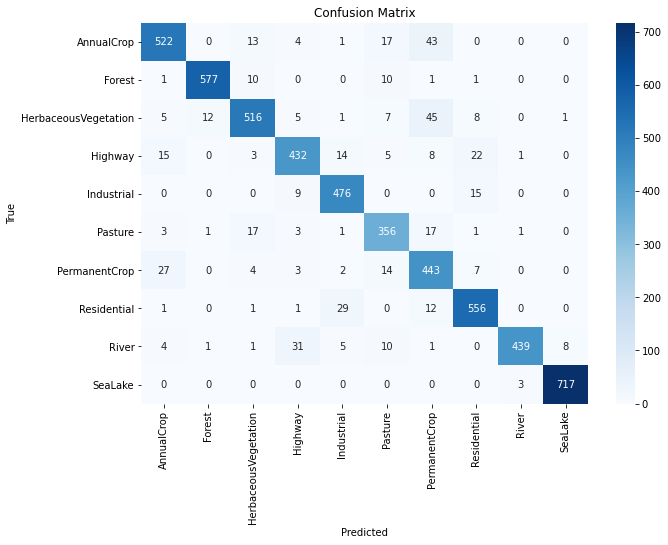

In [43]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
model.save("13_band_full.h5")